Edit/Notebook settings/Hardware accelerator/GPU

*#This code uses Physics-Informed Neural Networks PINNs (Raissi et al., 2019) to solve the inverse acoustic problem for an elliposidal low velocity anomaly in the domain with a point source (Synthetic Crosswell). See Case study 3 from paper Rasht-Behesht et al., 2021 for a full description of all parameters involved. Note they use input data from SPECFEM2D (Komatitsch  and  Tromp,  1999;  Tromp  et  al.,  2008) for training the PINN.*

In [ ]:
# Paquetes necesarios para el uso de la red PINN
import pickle
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
import scipy.interpolate as interpolate
import os

In [ ]:
# Selección de la GPU para las pruebas
os.environ['TF_XLA_FLAGS']='--tf_xla_enable_xla_devices'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Clears the default graph stack, resets the global default graph, and disable eager execution
tf.reset_default_graph()
tf.disable_eager_execution()

In [ ]:
x = tf.placeholder(tf.float64, shape=(None,1))
z = tf.placeholder(tf.float64, shape=(None,1))
t = tf.placeholder(tf.float64, shape=(None,1))

nx = 100 # number of nodes along x axis. used here to remove the specfem's
nz = 100 # absorbing regions from PINN's computational domain

n_abs =10 # number of nodes for absorbing B.C in both directions from specfem
n_absx = n_abs # nodes from left side of the domain
n_absz = n_abs # the top boundary is not absorbing

ax_spec = 1.5 # domain size in specfem before removing absorbing regions
az_spec = 0.5
xsf = 1.3 # x location of all the seismometers in specfem

dx = ax_spec/nx
dz = az_spec/nz
rho = 1.0

In [ ]:
ax = xsf-n_absx*dx # dimension of the domain in the x direction for PINNs training.
# Note they just need to remove the thickness of the absorbing B.C on the left since
# xsf is (must be) smaller than where the right side absorbing B.C starts
az = az_spec-n_absz*dz # dimension of the domain in the z direction
t_m = 0.5 # total time for PDE training.
t_st = 0.1 # this is when they take the first I.C from specfem
t_s = 0.5 # total time series used from the seismograms

s_spec = 5e-5 # specfem time stepsize
t01 = 2000*s_spec # initial disp. input at this time from spec
t02 = 2300*s_spec # sec "initial" disp. input at this time from spec instead of enforcing initial velocity
t_la = 5000*s_spec # test data for comparing specfem and trained PINNs

In [ ]:
n_event = 1 # number of seismic events
n_seis = 20 # number of input seismometers from SPECFEM; if events have different
# numbers of seismometers, you have to change the lines containing n_seis accordingly
z0_s = az # z location of the first seismometer from SPECFEM in PINN's refrence frame.Here it must
# be in km while in SPECFEM it's in meters. Note here they assume seismometers are
# NOT all on the surface and they are on a vertical line with the same x; the first
# seismometers is at the surface and the next one goes deeper

zl_s = 0.06-n_absz*dz # z location of the last seismometer at depth. this doesn't have
#to be zero and can be higher especially if you have absorbing B.C at the bottom, change
#this accordingly based on what you used from specfem

Lx = 3; # this is for scaling the wavespeed in the PDE via saling x coordinate
Lz = 3; # this is for scaling the wavespeed in the PDE via scaling z coordinate

In [ ]:
#Here they define the true ground velocity
def g(x,z,a,b,c,d):
  return ((x-c)**2/a**2+(z-d)**2/b**2)

alpha_true = 3-0.25*(1+tf.tanh(100*(1-g(x*Lx,z*Lz,0.18,0.1,1.0-n_absx*dx,0.3-n_absz*dz))))

ub = np.array([ax/Lx,az/Lz,(t_m-t_st)]).reshape(-1,1).T # normalization of the input to the NN
ub0 = np.array([ax/Lx,az/Lz]).reshape(-1,1).T # same for the inverse NN estimating the wave_speed

In [ ]:
def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev,dtype=tf.float64), dtype=tf.float64)


def neural_net(X, weights, biases):
    num_layers = len(weights) + 1
    H=2*(X/ub)-1 # normalization map to [-1 1]
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))


    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

def neural_net0(X, weights, biases):
    num_layers = len(weights) + 1
    H=2*(X/ub0)-1
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))


    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

In [ ]:
layers = [3]+[30]*3+[1] # layers for the NN approximating the scalar acoustic potential

L = len(layers)
weights = [xavier_init([layers[l], layers[l+1]]) for l in range(0, L-1)]
biases = [tf.Variable( tf.zeros((1, layers[l+1]),dtype=tf.float64)) for l in range(0, L-1)]
num_epoch = 10000001

layers0 = [2]+[20]*5+[1] # layers for the second NN to approximate the wavespeed

L0 = len(layers0)
weights0 = [xavier_init([layers0[l], layers0[l+1]]) for l in range(0, L0-1)]
biases0 = [tf.Variable( tf.zeros((1, layers0[l+1]),dtype=tf.float64)) for l in range(0, L0-1)]

learning_rate = 1.e-4
alpha_star = tf.tanh(neural_net0(tf.concat((x,z),axis=1), weights0, biases0))

In [ ]:
# Choose the box within which you are doing the inversion
z_st = 0.1-n_absz*dz # They are removing the absorbing layer from z_st to make it with reference to PINN's coordinate
z_fi = 0.45-n_absz*dz
x_st = 0.7-n_absx*dx
x_fi = 1.25-n_absx*dx
lld = 1000
alpha_bound = 0.5*(1+tf.tanh(lld*(z-z_st/Lz)))*0.5*(1+tf.tanh(lld*(-z+z_fi/Lz)))*0.5*(1+tf.tanh(lld*(x-x_st/Lx)))*0.5*(1+tf.tanh(lld*(-x+x_fi/Lx))) # confining the inversion to a box and not the whole region
alpha = 3+2*alpha_star*alpha_bound

In [ ]:
#### Scalar acoustic wave potential
phi = neural_net(tf.concat((x,z,t),axis=1), weights, biases)
P = (1/Lx)**2*tf.gradients(tf.gradients(phi,x)[0],x)[0] + (1/Lz)**2*tf.gradients(tf.gradients(phi,z)[0],z)[0]
eq = tf.gradients(tf.gradients(phi,t)[0],t)[0] - alpha**2*P # Scalar Wave equation
ux = tf.gradients(phi,x)[0] # u=grad(phi)
uz = tf.gradients(phi,z)[0]
Vel_x = tf.gradients(ux,t)[0] # velocity field
Vel_z = tf.gradients(uz,t)[0]

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
### PDE residuals
batch_size=40000
n_pde=batch_size*2000
print('batch_size',':',batch_size)

X_pde = np.load('drive/Shareddrives/Workshop/X_pde.npy')
X_pde[:,0] = X_pde[:,0] * ax/Lx
X_pde[:,1] = X_pde[:,1] * az/Lz
X_pde[:,2] = X_pde[:,2] * (t_m-t_st)

batch_size : 40000


In [ ]:
###initial conditions for all events
X0=np.loadtxt('drive/Shareddrives/Workshop/event1/wavefields/wavefield_grid_for_dumps_000.txt')# coordinates on which the wavefield output is recorded on specfem. It's the same for all the runs with the same meshing system in specfem

X0=X0/1000 # specfem works with meters unit so we need to convert them to Km
X0[:,0:1]=X0[:,0:1]/Lx # scaling the spatial domain
X0[:,1:2]=X0[:,1:2]/Lz # scaling the spatial domain
xz=np.concatenate((X0[:,0:1],X0[:,1:2]),axis=1)

n_ini=40

xx, zz = np.meshgrid(np.linspace(0,ax/Lx,n_ini),np.linspace(0,az/Lz,n_ini))
xxzz = np.concatenate((xx.reshape((-1,1)), zz.reshape((-1,1))),axis=1)
X_init1 = np.concatenate((xx.reshape((-1,1)),zz.reshape((-1,1)),0.0*np.ones((n_ini**2,1),dtype=np.float64)),axis=1) # for enforcing the disp I.C
X_init2 = np.concatenate((xx.reshape((-1,1)),zz.reshape((-1,1)),(t02-t01)*np.ones((n_ini**2,1),dtype=np.float64)),axis=1) # for enforcing the sec I.C, another snapshot of specfem

In [ ]:
# interpolationg specfem results in the non-absorbing part of the domain only
xf=n_absx*dx # start of the nonabsorbing part of the domain in specfem
zf=n_absz*dz
xxs, zzs = np.meshgrid(np.linspace(xf/Lx,xsf/Lx,n_ini),np.linspace(zf/Lz,az_spec/Lz,n_ini))
xxzzs = np.concatenate((xxs.reshape((-1,1)), zzs.reshape((-1,1))),axis=1)
u_scl=1/3640 # scaling the output data to cover [-1 1] interval

import os

# uploading the wavefields from specfem
wfs = sorted(os.listdir('drive/Shareddrives/Workshop/event1/wavefields/.'))
U0 = [np.loadtxt('drive/Shareddrives/Workshop/event1/wavefields/'+f) for f in wfs]

U_ini1 = interpolate.griddata(xz, U0[0], xxzzs, fill_value=0.0)
U_ini1x=U_ini1[:,0:1]/u_scl
U_ini1z=U_ini1[:,1:2]/u_scl


U_ini2 = interpolate.griddata(xz, U0[1], xxzzs, fill_value=0.0)
U_ini2x=U_ini2[:,0:1]/u_scl
U_ini2z=U_ini2[:,1:2]/u_scl

U_spec = interpolate.griddata(xz, U0[2], xxzzs, fill_value=0.0)#Test data
U_specx=U_spec[:,0:1]/u_scl
U_specz=U_spec[:,1:2]/u_scl

In [ ]:
# the first event's data has been uploaded above and below
# the rest of the n-1 events will be added
for ii in range(n_event-1):
    wfs = sorted(os.listdir('event'+str(ii+2)+'/wavefields/.'))
    U0 = [np.loadtxt('event'+str(ii+2)+'/wavefields/'+f) for f in wfs]

    U_ini1 = interpolate.griddata(xz, U0[0], xxzzs, fill_value=0.0)
    U_ini1x +=U_ini1[:,0:1]/u_scl
    U_ini1z +=U_ini1[:,1:2]/u_scl


    U_ini2 = interpolate.griddata(xz, U0[1], xxzzs, fill_value=0.0)
    U_ini2x +=U_ini2[:,0:1]/u_scl
    U_ini2z +=U_ini2[:,1:2]/u_scl

    U_spec = interpolate.griddata(xz, U0[2], xxzzs, fill_value=0.0)
    U_specx +=U_spec[:,0:1]/u_scl
    U_specz +=U_spec[:,1:2]/u_scl

In [ ]:
# create the folder to save the results
!mkdir sample_data/PINN/

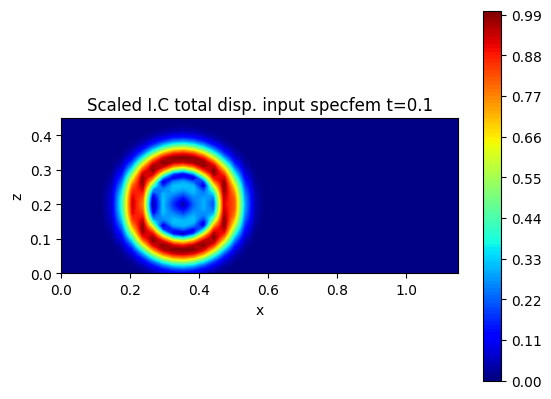

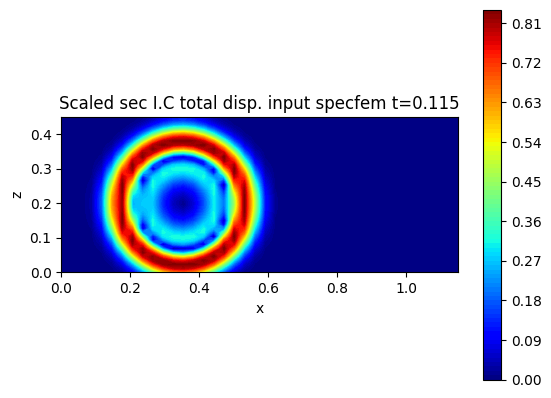

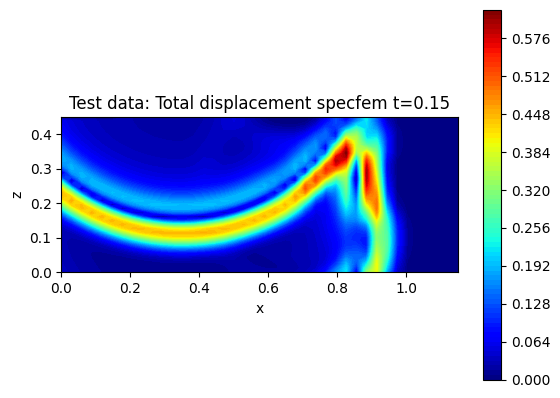

In [ ]:
################### plots of inputs for sum of the events
fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, np.sqrt(U_ini1x**2+U_ini1z**2).reshape(xx.shape),100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Scaled I.C total disp. input specfem t='+str(t01))
plt.colorbar()
plt.axis('scaled')
plt.savefig('sample_data/PINN/Ini_total_disp_spec_sumEvents.png', dpi=400)
plt.show()
plt.close(fig)



fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, np.sqrt(U_ini2x**2+U_ini2z**2).reshape(xx.shape),100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Scaled sec I.C total disp. input specfem t='+str(round(t02, 4)))
plt.colorbar()
plt.axis('scaled')
plt.savefig('sample_data/PINN/sec_wavefield_input_spec_sumEvents.png', dpi=400)
plt.show()
plt.close(fig)



fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, np.sqrt(U_specx**2+U_specz**2).reshape(xx.shape),100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Test data: Total displacement specfem t='+str(round((t_la-t01), 4)))
plt.colorbar()
plt.axis('scaled')
plt.savefig('sample_data/PINN/total_disp_spec_testData_sumEvents.png', dpi=400)
plt.show()
plt.close(fig)

In [ ]:
################# ----Z component seismograms
#################input seismograms for the first event
import os
sms = sorted(os.listdir('drive/Shareddrives/Workshop/event1/seismograms/.'))
smsz = [f for f in sms if f[-6]=='Z']#Z cmp seismos
seismo_listz = [np.loadtxt('drive/Shareddrives/Workshop/event1/seismograms/'+f) for f in smsz] # Z cmp seismos

t_spec =- seismo_listz[0][0,0]+seismo_listz[0][:,0] # specfem's time doesn't start from zero for the seismos, so they shift it forward to zero
cut_u = t_spec>t_s # here they include only part of the seismograms from specfem that are within PINNs' training time domain which is [t_st t_m]
cut_l = t_spec<t_st # Cutting the seismograms to only after the time the first snapshot from specfem is used for PINNs
l_su = len(cut_u)-sum(cut_u) # this is the index of the time axis in specfem after which t>t_m
l_sl = sum(cut_l)

l_f = 100 # subsampling seismograms from specfem
index = np.arange(l_sl,l_su,l_f) # subsampling every l_s time steps from specfem in the training interval
l_sub = len(index)
t_spec_sub = t_spec[index].reshape((-1,1)) # subsampled time axis of specfem for the seismograms
t_spec_sub = t_spec_sub-t_spec_sub[0] # shifting the time axis back to zero. length of t_spec_sub must be equal to t_m-t_st

for ii in range(len(seismo_listz)):
    seismo_listz[ii]=seismo_listz[ii][index]

Sz = seismo_listz[0][:,1].reshape(-1,1)
for ii in range(len(seismo_listz)-1):
    Sz=np.concatenate((Sz,seismo_listz[ii+1][:,1].reshape(-1,1)),axis=0)

In [ ]:
#################################################################
#######input seismograms for the rest of the events added to the first event
for ii in range(n_event-1):
    sms = sorted(os.listdir('event'+str(ii+2)+'/seismograms/.'))
    smsz = [f for f in sms if f[-6]=='Z']#Z cmp seismos
    seismo_listz = [np.loadtxt('event'+str(ii+2)+'/seismograms/'+f) for f in smsz]

    for jj in range(len(seismo_listz)):
        seismo_listz[jj]=seismo_listz[jj][index]


    Sze=seismo_listz[0][:,1].reshape(-1,1)
    for jj in range(len(seismo_listz)-1):
       Sze=np.concatenate((Sze,seismo_listz[jj+1][:,1].reshape(-1,1)),axis=0)

    Sz +=Sze
###########################################################

In [ ]:
Sz = Sz/u_scl # scaling the sum of all seismogram inputs

# X_S is the training collection of input coordinates in space-time for all seismograms
X_S = np.empty([int(np.size(Sz)), 3])

d_s = np.abs((zl_s-z0_s))/(n_seis-1) # the distance between seismometers

for i in range(len(seismo_listz)):
  X_S[i*l_sub:(i+1)*l_sub,] = np.concatenate((ax/Lx*np.ones((l_sub,1),dtype=np.float64), \
                               (z0_s-i*d_s)/Lz*np.ones((l_sub,1),dtype=np.float64),t_spec_sub),axis=1)

In [ ]:
################# ----X component seismograms
#################input seismograms for the first event

import os
sms = sorted(os.listdir('drive/Shareddrives/Workshop/event1/seismograms/.'))
smsx = [f for f in sms if f[-6]=='X'] # X cmp seismos
seismo_listx = [np.loadtxt('drive/Shareddrives/Workshop/event1/seismograms/'+f) for f in smsx] # X cmp seismos

for ii in range(len(seismo_listx)):
    seismo_listx[ii]=seismo_listx[ii][index]

Sx=seismo_listx[0][:,1].reshape(-1,1)
for ii in range(len(seismo_listx)-1):
    Sx=np.concatenate((Sx,seismo_listx[ii+1][:,1].reshape(-1,1)),axis=0)

In [ ]:
#################################################################
#######input seismograms for the rest of the events added to the first event

for ii in range(n_event-1):
    sms = sorted(os.listdir('event'+str(ii+2)+'/seismograms/.'))
    smsx = [f for f in sms if f[-6]=='X']#X cmp seismos
    seismo_listx = [np.loadtxt('event'+str(ii+2)+'/seismograms/'+f) for f in smsx]

    for jj in range(len(seismo_listx)):
        seismo_listx[jj]=seismo_listx[jj][index]



    Sxe=seismo_listx[0][:,1].reshape(-1,1)
    for jj in range(len(seismo_listx)-1):
       Sxe=np.concatenate((Sxe,seismo_listx[jj+1][:,1].reshape(-1,1)),axis=0)

    Sx +=Sxe
###########################################################

In [ ]:
Sx = Sx/u_scl # scaling the sum of all seismogram inputs



####  BCs: Free stress on top and no BC for other sides (absorbing)
bcxn = 100
bctn = 50
x_vec = np.random.rand(bcxn,1)*ax/Lx
t_vec = np.random.rand(bctn,1)*(t_m-t_st)
xxb, ttb = np.meshgrid(x_vec, t_vec)
X_BC_t = np.concatenate((xxb.reshape((-1,1)),az/Lz*np.ones((xxb.reshape((-1,1)).shape[0],1)),ttb.reshape((-1,1))),axis=1)

N1 = batch_size
N2 = X_init1.shape[0]
N3 = X_init2.shape[0]
N4 = X_S.shape[0]

XX = np.concatenate((X_pde[0:batch_size], X_init1,X_init2, X_S,X_BC_t),axis=0)

feed_dict1 = { x: XX[:,0:1], z: XX[:,1:2], t: XX[:,2:3]} # This dictionary is for training

loss_pde = tf.reduce_mean(tf.square(eq[:N1,0:1]))
loss_init_disp1 = tf.constant(0.0, dtype=tf.float64)
loss_init_disp2 = tf.constant(0.0, dtype=tf.float64)

loss_init_disp1 = tf.reduce_mean(tf.square(ux[N1:(N1+N2),0:1]-U_ini1x)) \
          + tf.reduce_mean(tf.square(uz[N1:(N1+N2),0:1]-U_ini1z))

loss_init_disp2 = tf.reduce_mean(tf.square(ux[(N1+N2):(N1+N2+N3),0:1]-U_ini2x)) \
          + tf.reduce_mean(tf.square(uz[(N1+N2):(N1+N2+N3),0:1]-U_ini2z))

loss_seism = tf.reduce_mean(tf.square(ux[(N1+N2+N3):(N1+N2+N3+N4),0:1]-Sx)) \
          + tf.reduce_mean(tf.square(uz[(N1+N2+N3):(N1+N2+N3+N4),0:1]-Sz))

loss_BC = tf.reduce_mean(tf.square(P[(N1+N2+N3+N4):,0:1]))

loss = 1e-1*loss_pde + loss_init_disp1 +loss_init_disp2+loss_seism+1e-1*loss_BC

In [ ]:
optimizer_Adam = tf.train.AdamOptimizer(learning_rate)
train_op_Adam = optimizer_Adam.minimize(loss)

xx0, zz0 = xx.reshape((-1,1)), zz.reshape((-1,1))

X_eval01=np.concatenate((xx0,zz0,0*np.ones((xx0.shape[0],1))),axis=1) # evaluating PINNs at time=0
X_eval02=np.concatenate((xx0,zz0,(t02-t01)*np.ones((xx0.shape[0],1))),axis=1) # evaluating PINNs at time when the second input from specfem is provided
X_evalt=np.concatenate((xx0,zz0,(t_la-t01)*np.ones((xx0.shape[0],1))),axis=1) # evaluating PINNs at a later time>0

feed_dict01 = { x: X_eval01[:,0:1], z: X_eval01[:,1:2], t: X_eval01[:,2:3]} # this dictionary is for evaluating the initial condition recovered from PINNs on new test points other than the ones used for training
feed_dict02 = { x: X_eval02[:,0:1], z: X_eval02[:,1:2], t: X_eval02[:,2:3]} # this dictionary is for evaluating the initial condition recovered from PINNs on new test points other than the ones used for training
feed_dict2 = { x: X_evalt[:,0:1], z: X_evalt[:,1:2], t: X_evalt[:,2:3]} # this dictionary is for evaluating PINNs at a later time>0
feed_dict_seism={ x: X_S[:,0:1], z: X_S[:,1:2], t: X_S[:,2:3]}
i=int(-1)
loss_eval=np.zeros((1,7))
loss_rec=np.empty((0,7))

with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      alpha_true0=sess.run([alpha_true], feed_dict =feed_dict01 ) # note alpha takes two variables but feed_dict01 has three input. but it's ok and won't cause any issues

alpha_true0 = alpha_true0[0].reshape((xx.shape))

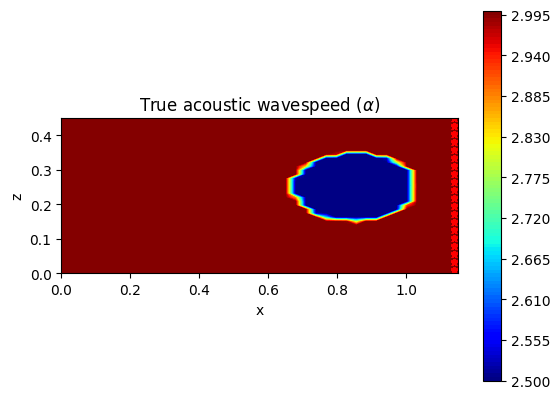

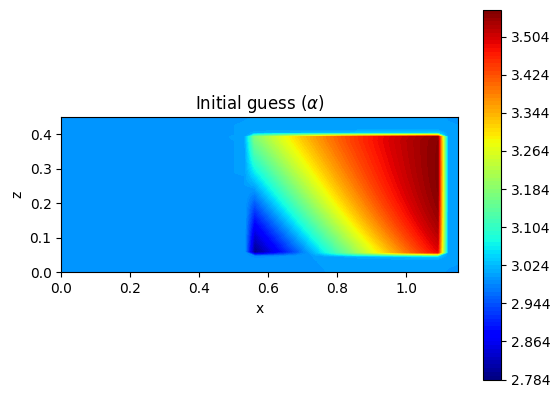

In [ ]:
fig = plt.figure()
plt.contourf(Lx*xx, Lz*zz, alpha_true0.reshape((xx.shape)), 100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'True acoustic wavespeed ($\alpha$)')
plt.colorbar()
plt.axis('scaled')
plt.plot(Lx*0.99*X_S[:,0],Lz*X_S[:,1],'r*',markersize=5)
plt.savefig('sample_data/PINN/True_wavespeed.png', dpi=400)
plt.show()
plt.close(fig)

with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      alpha_plot=sess.run([alpha], feed_dict =feed_dict01 )

alpha_plot = alpha_plot[0].reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, alpha_plot.reshape((xx.shape)), 100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'Initial guess ($\alpha$)')
plt.colorbar()
plt.axis('scaled')
plt.savefig('sample_data/PINN/Ini_guess_wavespeed.png', dpi=400)
plt.show()
plt.close(fig)

Time:  1.5346912470000689
Epoch:  0 , Loss:  2.729915035261819 , Loss_pde:  12.224051439256503 , Loss_init_disp1:  0.5411589496261291
, Loss_init_disp2:  0.5416519124109961 Loss_seism:  0.4087268199012028 Loss_stress:  0.1597220939784076


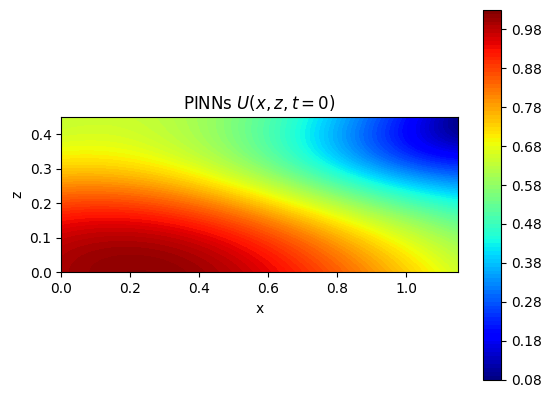

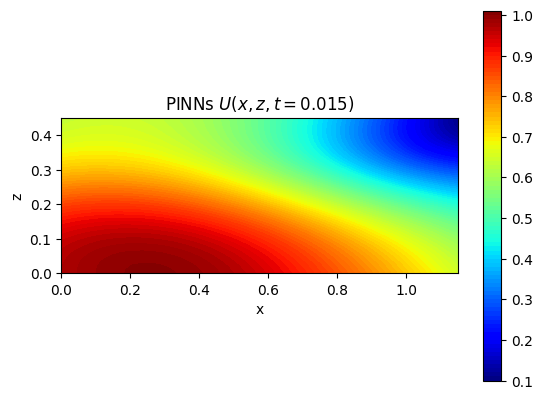

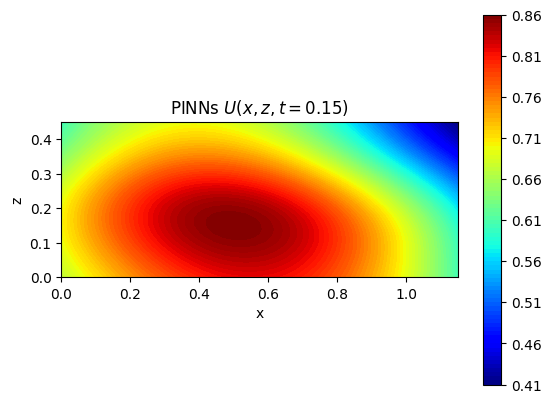

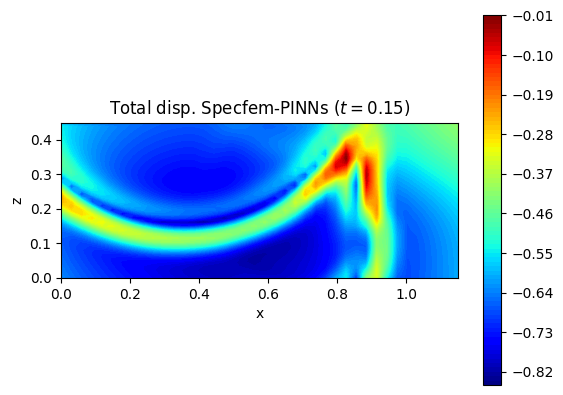

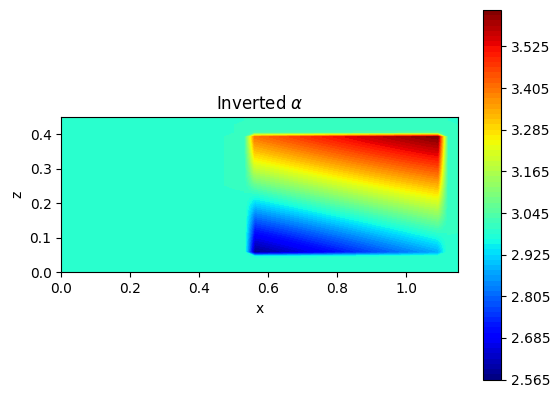

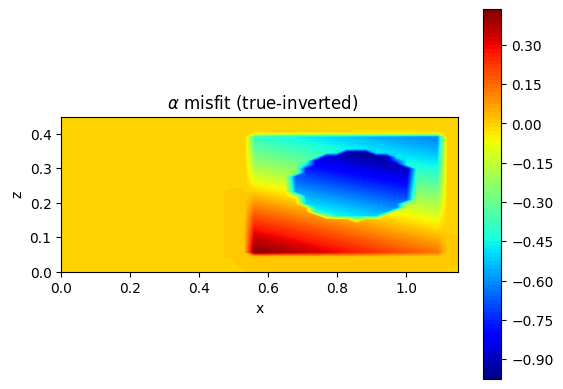

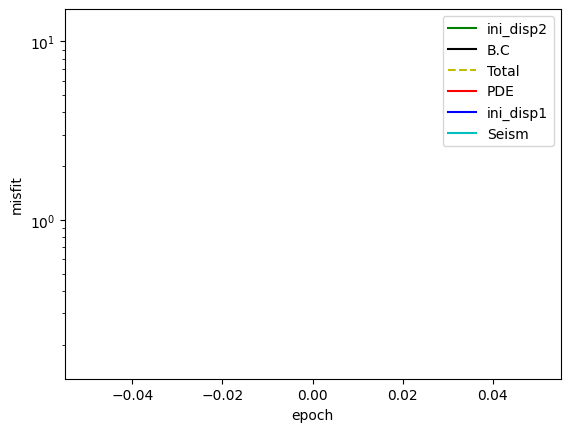

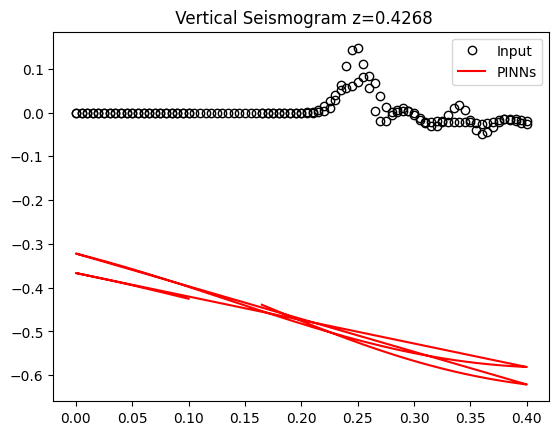

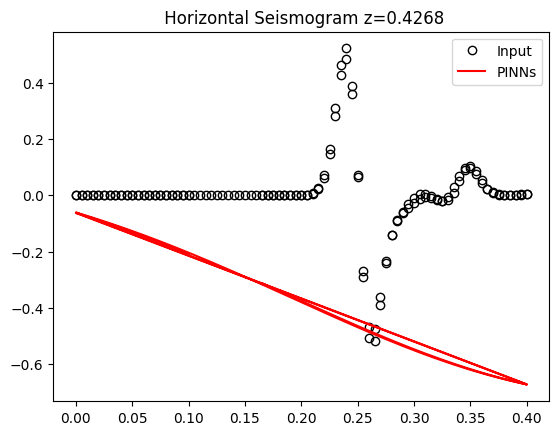

Time:  1606.123646563
Epoch:  10000 , Loss:  0.11225012934430756 , Loss_pde:  0.02363595216744957 , Loss_init_disp1:  0.04964914026216965
, Loss_init_disp2:  0.05061373568223833 Loss_seism:  0.008937015926514084 Loss_stress:  0.006866422566405454


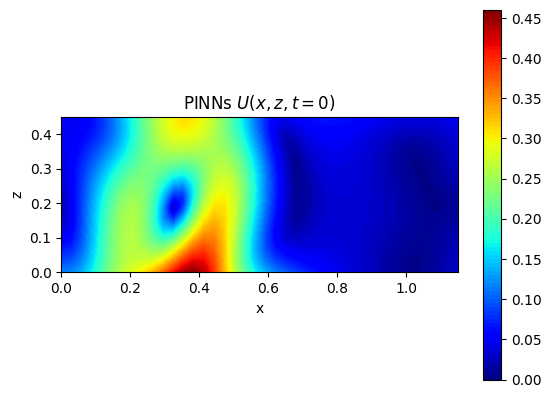

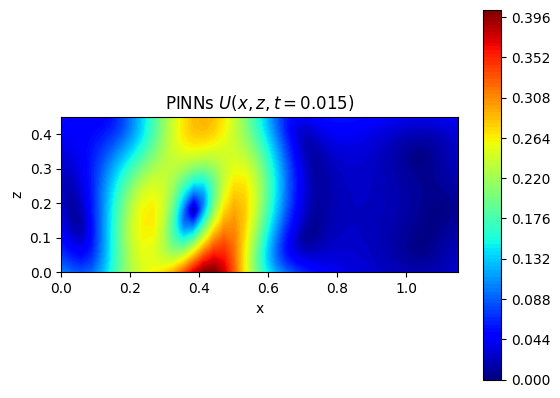

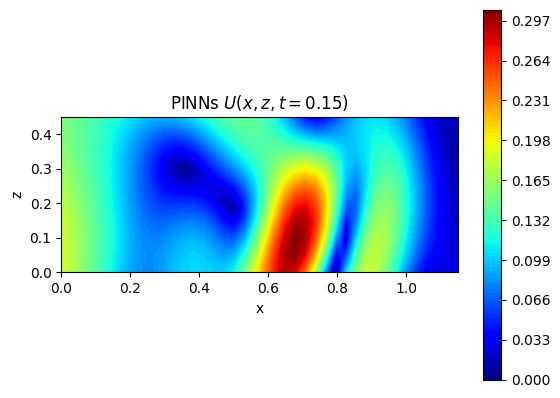

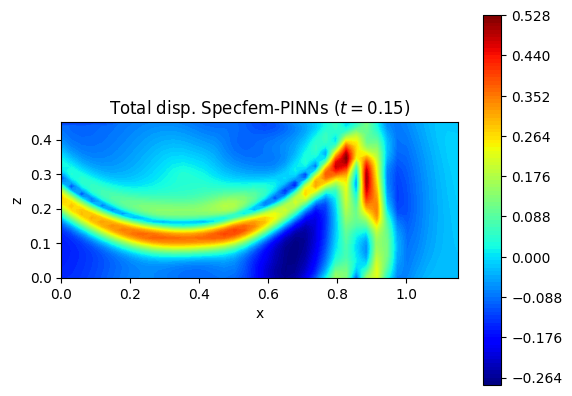

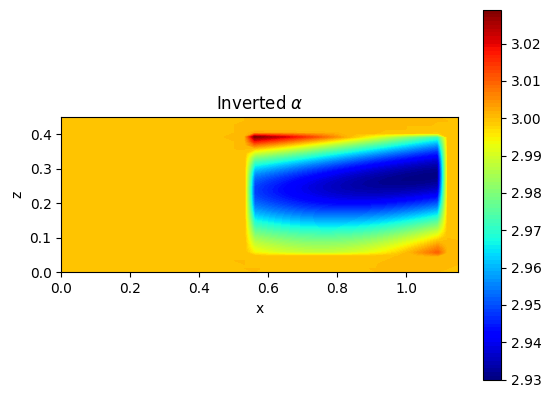

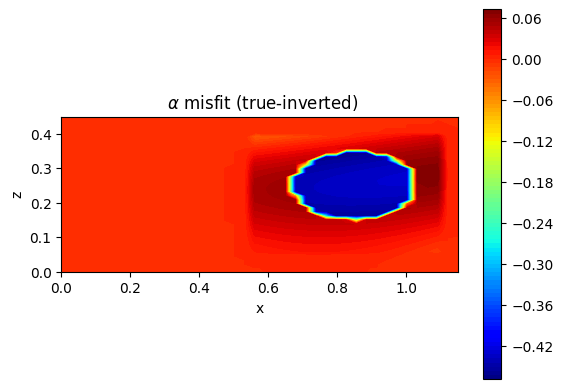

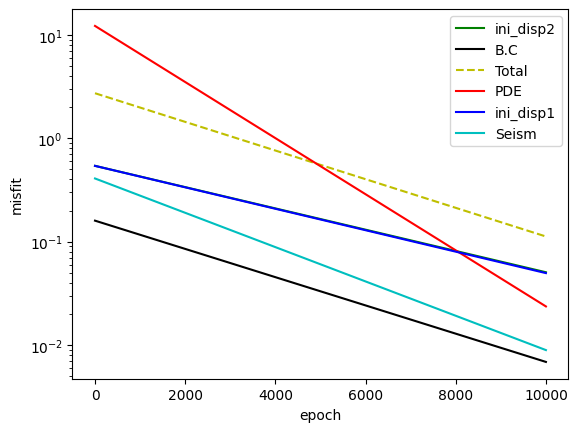

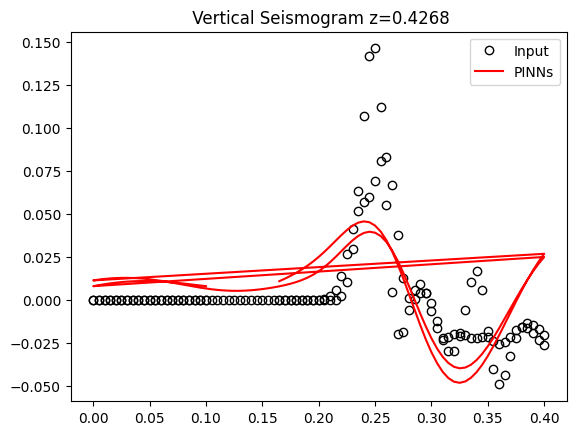

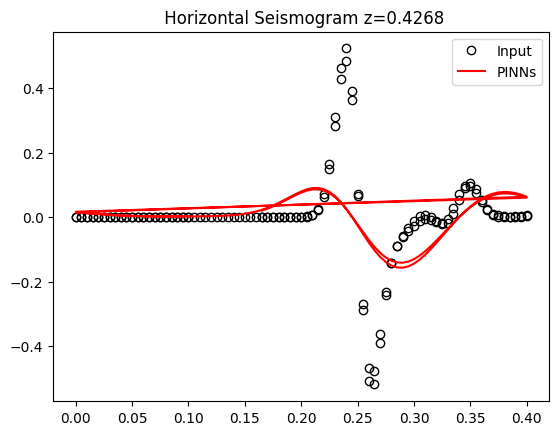

In [ ]:
bbn=0
with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())

      start = timeit.default_timer()
      for epoch in range(num_epoch):

          sess.run(train_op_Adam, feed_dict = feed_dict1)

          if epoch % 10000 == 0:
              stop = timeit.default_timer()
              print('Time: ', stop - start)
              loss_val, loss_pde_val, loss_init_disp1_val,loss_init_disp2_val,loss_seism_val,loss_BC_val \
              = sess.run([loss, loss_pde, loss_init_disp1,loss_init_disp2,loss_seism,loss_BC], feed_dict = feed_dict1)

              print ('Epoch: ', epoch, ', Loss: ', loss_val, ', Loss_pde: ', loss_pde_val, ', Loss_init_disp1: ', loss_init_disp1_val)
              print (', Loss_init_disp2: ', loss_init_disp2_val,'Loss_seism: ', loss_seism_val,'Loss_stress: ', loss_BC_val)

              ux01=sess.run([ux], feed_dict =feed_dict01 )
              uz01=sess.run([uz], feed_dict =feed_dict01 )
              ux02=sess.run([ux], feed_dict =feed_dict02 )
              uz02=sess.run([uz], feed_dict =feed_dict02 )
              uxt=sess.run([ux], feed_dict =feed_dict2 )
              uzt=sess.run([uz], feed_dict =feed_dict2 )
              uz_seism_pred=sess.run([uz], feed_dict =feed_dict_seism )
              ux_seism_pred=sess.run([ux], feed_dict =feed_dict_seism )
              alpha0=sess.run([alpha], feed_dict =feed_dict01 )
              i=i+1
              loss_eval[0,0],loss_eval[0,1],loss_eval[0,2],loss_eval[0,3],loss_eval[0,4],loss_eval[0,5],loss_eval[0,6]\
              =epoch,loss_val, loss_pde_val, loss_init_disp1_val,loss_init_disp2_val,loss_seism_val,loss_BC_val

              loss_rec= np.concatenate((loss_rec,loss_eval),axis=0)

              #####Defining a new training batch for both PDE and B.C input data
              x_vec = np.random.rand(bcxn,1)*ax/Lx
              t_vec = np.random.rand(bctn,1)*(t_m-t_st)
              xxb, ttb = np.meshgrid(x_vec, t_vec)
              X_BC_t = np.concatenate((xxb.reshape((-1,1)),az/Lz*np.ones((xxb.reshape((-1,1)).shape[0],1)),ttb.reshape((-1,1))),axis=1)

              bbn=bbn+1
              XX = np.concatenate((X_pde[bbn*batch_size:(bbn+1)*batch_size], X_init1,X_init2,X_S,X_BC_t),axis=0)
              feed_dict1 = { x: XX[:,0:1], z: XX[:,1:2], t: XX[:,2:3]} # This dictionary is for training

              U_PINN01=((ux01[0].reshape(xx.shape))**2+(uz01[0].reshape(xx.shape))**2)**0.5
              U_PINN02=((ux02[0].reshape(xx.shape))**2+(uz02[0].reshape(xx.shape))**2)**0.5
              U_PINNt=((uxt[0].reshape(xx.shape))**2+(uzt[0].reshape(xx.shape))**2)**0.5
              U_diff=np.sqrt(U_specx**2+U_specz**2).reshape(xx.shape)-U_PINNt
              fig = plt.figure()
              plt.contourf(xx*Lx, zz*Lz, U_PINN01,100, cmap='jet')
              plt.xlabel('x')
              plt.ylabel('z')
              plt.title(r'PINNs $U(x,z,t=$'+str(0)+r'$)$')
              plt.colorbar()
              plt.axis('scaled')
              plt.savefig('sample_data/PINN/Total_Predicted_dispfield_t='+str(0)+'.png',dpi=400)
              plt.show()
              plt.close(fig)
              fig = plt.figure()
              plt.contourf(xx*Lx, zz*Lz, U_PINN02,100, cmap='jet')
              plt.xlabel('x')
              plt.ylabel('z')
              plt.title(r'PINNs $U(x,z,t=$'+str(round(t02-t01, 4))+r'$)$')
              plt.colorbar()
              plt.axis('scaled')
              plt.savefig('sample_data/PINN/Total_Predicted_dispfield_t='+str(round(t02-t01, 4))+'.png',dpi=400)
              plt.show()
              plt.close(fig)
              fig = plt.figure()
              plt.contourf(xx*Lx, zz*Lz, U_PINNt,100, cmap='jet')
              plt.xlabel('x')
              plt.ylabel('z')
              plt.title(r'PINNs $U(x,z,t=$'+str(round((t_la-t01), 4))+r'$)$')
              plt.colorbar()
              plt.axis('scaled')
              plt.savefig('sample_data/PINN/Total_Predicted_dispfield_t='+str(round((t_la-t01), 4))+'.png',dpi=400)
              plt.show()
              plt.close(fig)

              fig = plt.figure()
              plt.contourf(xx*Lx, zz*Lz, U_diff,100, cmap='jet')
              plt.xlabel('x')
              plt.ylabel('z')
              plt.title(r'Total disp. Specfem-PINNs ($t=$'+str(round((t_la-t01), 4))+r'$)$')
              plt.colorbar()
              plt.axis('scaled')
              plt.savefig('sample_data/PINN/pointwise_Error_spec_minus_PINNs_t='+str(round((t_la-t01), 4))+'.png',dpi=400)
              plt.show()
              plt.close(fig)

              fig = plt.figure()
              plt.contourf(xx*Lx, zz*Lz, alpha0[0].reshape(xx.shape),100, cmap='jet')
              plt.xlabel('x')
              plt.ylabel('z')
              plt.title(r'Inverted $\alpha$')
              plt.colorbar()
              plt.axis('scaled')
              plt.savefig('sample_data/PINN/inverted_alpha.png',dpi=400)
              plt.show()
              plt.close(fig)

              fig = plt.figure()
              plt.contourf(xx*Lx, zz*Lx, alpha_true0-(alpha0[0].reshape(xx.shape)),100, cmap='jet')
              plt.xlabel('x')
              plt.ylabel('z')
              plt.title(r' $\alpha$ misfit (true-inverted)')
              plt.colorbar()
              plt.axis('scaled')
              plt.savefig('sample_data/PINN/alpha_misfit.png',dpi=400)
              plt.show()
              plt.close(fig)

              fig = plt.figure()
              plt.plot(loss_rec[0:,0], loss_rec[0:,4],'g',label='ini_disp2')
              plt.plot(loss_rec[0:,0], loss_rec[0:,6],'black',label='B.C')
              plt.plot(loss_rec[0:,0], loss_rec[0:,1],'--y',label='Total')
              plt.plot(loss_rec[0:,0], loss_rec[0:,2],'r',label='PDE')
              plt.plot(loss_rec[0:,0], loss_rec[0:,3],'b',label='ini_disp1')
              plt.plot(loss_rec[0:,0], loss_rec[0:,5],'c',label='Seism')
              plt.yscale("log")
              plt.xlabel('epoch')
              plt.ylabel('misfit')
              plt.legend()
              plt.savefig('sample_data/PINN/misfit.png',dpi=400)
              plt.show()
              plt.close(fig)

              fig = plt.figure()
              plt.plot(X_S[600:750,2],Sz[600:750],'ok',mfc='none',label='Input')
              plt.plot(X_S[600:750,2],uz_seism_pred[0][600:750],'r',label='PINNs')
              plt.legend()
              plt.title(r' Vertical Seismogram z='+str(round(az-d_s, 4)))
              plt.savefig('sample_data/PINN/ZSeismograms_compare_z='+str(round(az-d_s, 4))+'.png',dpi=400)
              plt.show()
              plt.close(fig)

              fig = plt.figure()
              plt.plot(X_S[600:750,2],Sx[600:750],'ok',mfc='none',label='Input')
              plt.plot(X_S[600:750,2],ux_seism_pred[0][600:750],'r',label='PINNs')
              plt.legend()
              plt.title(r' Horizontal Seismogram z='+str(round(az-d_s, 4)))
              plt.savefig('sample_data/PINN/XSeismograms_compare_z='+str(round(az-d_s, 4))+'.png',dpi=400)
              plt.show()
              plt.close(fig)

              w_f=sess.run(weights)#saving weights
              b_f=sess.run(biases)#saving biases
              w_alph=sess.run(weights0)#saving weights for the inverse NN
              b_alph=sess.run(biases0)
              with open('recorded_weights.pickle', 'wb') as f:
                   pickle.dump(['The first tensor contains weights, the second biases and the third losses',w_f,b_f,w_alph,b_alph,loss_rec], f)

# **Inferred section: recorded_weights_x.pickle, with x=0, 10000, 20000, .. 400000**

> Indented block



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
obj = pd.read_pickle(r'drive/Shareddrives/Workshop/weights/recorded_weights_350000.pickle')
w_f=obj[1]
b_f=obj[2]
w_alph=obj[3]
b_alph=obj[4]
loss_rec=obj[5]
!mkdir sample_data/PINN/
fig = plt.figure()
plt.plot(loss_rec[0:,0], loss_rec[0:,4],'g',label='ini_disp2')
plt.plot(loss_rec[0:,0], loss_rec[0:,6],'black',label='B.C')
plt.plot(loss_rec[0:,0], loss_rec[0:,1],'--y',label='Total')
plt.plot(loss_rec[0:,0], loss_rec[0:,2],'r',label='PDE')
plt.plot(loss_rec[0:,0], loss_rec[0:,3],'b',label='ini_disp1')
plt.plot(loss_rec[0:,0], loss_rec[0:,5],'c',label='Seism')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('misfit')
plt.legend()
plt.savefig('sample_data/PINN/Infered_misfit.png',dpi=400)
plt.show()
plt.close(fig)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


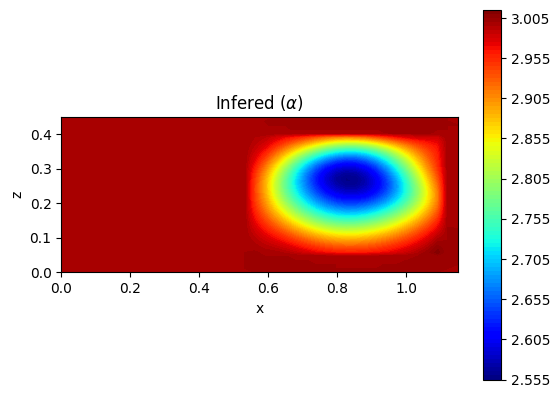

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
x = tf.placeholder(tf.float64, shape=(None,1))
z = tf.placeholder(tf.float64, shape=(None,1))
t = tf.placeholder(tf.float64, shape=(None,1))

def neural_net(X, weights, biases):
    num_layers = len(weights) + 1
    H=2*(X/ub)-1#normalization map to [-1 1]
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))


    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

def neural_net0(X, weights, biases):
    num_layers = len(weights) + 1
    H=2*(X/ub0)-1
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))


    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

import numpy as np

nx=100#number of nodes along x axis. used here to remove the specfem's absorbing regions from PINN's computational domain
nz=100

n_abs=10#  # of nodes for absorbing B.C in both directions from specfem
n_absx=n_abs# nodes from left side of the domain
n_absz=n_abs#the top boundary is not absorbing


ax_spec=1.5#domain size in specfem before removing absorbing regions
az_spec=0.5
xsf=1.3#x location of all the seismometers in specfem

dx=ax_spec/nx
dz=az_spec/nz
rho=1.0
ax=xsf-n_absx*dx#dimension of the domain in the x direction for PINNs training. Note
#we just need to remove the thickness of the absorbing B.C on the left since
#xsf is (must be) smaller than where the right side absorbing B.C starts
az=az_spec-n_absz*dz#dimension of the domain in the z direction
t_m=0.5#total time for PDE training.
t_st=0.1#this is when we take the first I.C from specfem
t_s=0.5#total time series used from the seismograms
Lx=3;#this is for scaling the wavespeed in the PDE via saling x coordinate
Lz=3;#this is for scaling the wavespeed in the PDE via scaling z coordinate

ub=np.array([ax/Lx,az/Lz,(t_m-t_st)]).reshape(-1,1).T# normalization of the input to the NN
ub0=np.array([ax/Lx,az/Lz]).reshape(-1,1).T#same for the inverse NN estimating the wave_speed

alpha_star=tf.tanh(neural_net0(tf.concat((x,z),axis=1), w_alph, b_alph))
z_st=0.1-n_absz*dz#We are removing the absorbing layer from z_st to make it with reference to PINN's coordinate
z_fi=0.45-n_absz*dz
x_st=0.7-n_absx*dx
x_fi=1.25-n_absx*dx
lld=1000
alpha_bound=0.5*(1+tf.tanh(lld*(z-z_st/Lz)))*0.5*(1+tf.tanh(lld*(-z+z_fi/Lz)))*0.5*(1+tf.tanh(lld*(x-x_st/Lx)))*0.5*(1+tf.tanh(lld*(-x+x_fi/Lx)))#confining the inversion to a box and not the whole region
alpha=3+2*alpha_star*alpha_bound

phi = neural_net(tf.concat((x,z,t),axis=1), w_f, b_f)
P = (1/Lx)**2*tf.gradients(tf.gradients(phi,x)[0],x)[0] + (1/Lz)**2*tf.gradients(tf.gradients(phi,z)[0],z)[0]

n_ini=40
xx, zz = np.meshgrid(np.linspace(0,ax/Lx,n_ini),np.linspace(0,az/Lz,n_ini))

xx0, zz0 = xx.reshape((-1,1)), zz.reshape((-1,1))
X_eval01=np.concatenate((xx0,zz0,0*np.ones((xx0.shape[0],1))),axis=1)#evaluating PINNs at time=0
feed_dict01 = { x: X_eval01[:,0:1], z: X_eval01[:,1:2], t: X_eval01[:,2:3]}#this dictionary is for evaluating the initial condition recovered from PINNs on new test points other than the ones used for training

with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      alpha_plot=sess.run([alpha], feed_dict =feed_dict01 )

alpha_plot = alpha_plot[0].reshape(xx.shape)


fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, alpha_plot.reshape((xx.shape)), 100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'Infered ($\alpha$)')
plt.colorbar()
plt.axis('scaled')
plt.savefig('sample_data/PINN/Infered_wavespeed.png', dpi=400)
plt.show()
plt.close(fig)

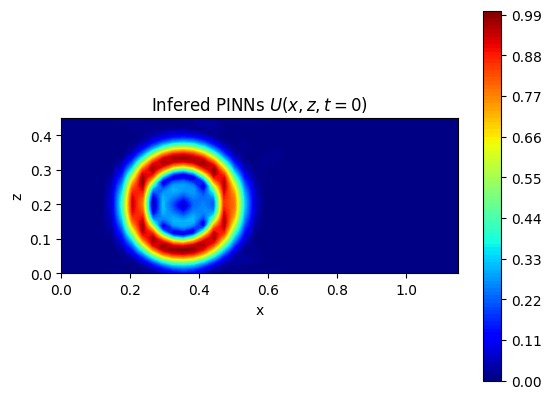

In [ ]:
ux= tf.gradients(phi,x)[0] #u=grad(phi)
uz= tf.gradients(phi,z)[0]
with tf.Session() as sess:
    ux01=sess.run([ux], feed_dict =feed_dict01 )
    uz01=sess.run([uz], feed_dict =feed_dict01 )

U_PINN01=((ux01[0].reshape(xx.shape))**2+(uz01[0].reshape(xx.shape))**2)**0.5

fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, U_PINN01,100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'Infered PINNs $U(x,z,t=$'+str(0)+r'$)$')
plt.colorbar()
plt.axis('scaled')
plt.savefig('sample_data/PINN/Infered_Predicted_dispfield_t='+str(0)+'.png',dpi=400)
plt.show()
plt.close(fig)

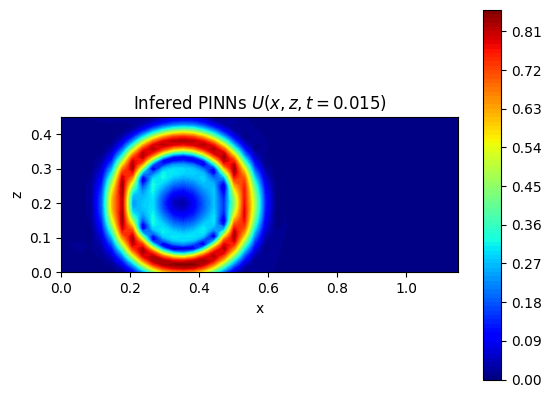

In [ ]:
s_spec=5e-5#specfem time stepsize
t01=2000*s_spec#initial disp. input at this time from spec
t02=2300*s_spec#sec "initial" disp. input at this time from spec instead of enforcing initial velocity
t_la=5000*s_spec# test data for comparing specfem and trained PINNs

X_eval02=np.concatenate((xx0,zz0,(t02-t01)*np.ones((xx0.shape[0],1))),axis=1)#evaluating PINNs at time when the second input from specfem is provided
feed_dict02 = { x: X_eval02[:,0:1], z: X_eval02[:,1:2], t: X_eval02[:,2:3]}#this dictionary is for evaluating the initial condition recovered from PINNs on new test points other than the ones used for training

with tf.Session() as sess:
    ux02=sess.run([ux], feed_dict =feed_dict02 )
    uz02=sess.run([uz], feed_dict =feed_dict02 )

U_PINN02=((ux02[0].reshape(xx.shape))**2+(uz02[0].reshape(xx.shape))**2)**0.5

fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, U_PINN02,100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'Infered PINNs $U(x,z,t=$'+str(round(t02-t01, 4))+r'$)$')
plt.colorbar()
plt.axis('scaled')
plt.savefig('sample_data/PINN/Infered_Predicted_dispfield_t='+str(round(t02-t01, 4))+'.png',dpi=400)
plt.show()
plt.close(fig)

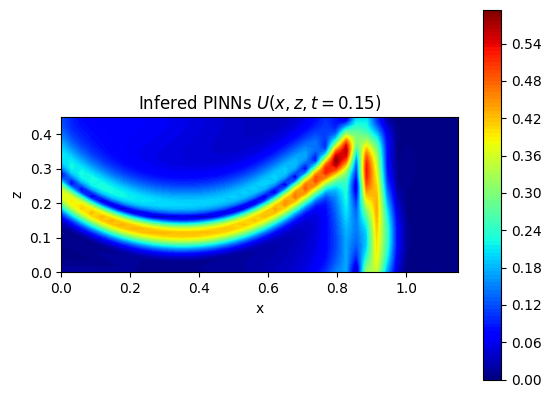

In [ ]:
X_evalt=np.concatenate((xx0,zz0,(t_la-t01)*np.ones((xx0.shape[0],1))),axis=1)#evaluating PINNs at a later time>0
feed_dict2 = { x: X_evalt[:,0:1], z: X_evalt[:,1:2], t: X_evalt[:,2:3]}#this dictionary is for evaluating PINNs at a later time>0
with tf.Session() as sess:
    uxt=sess.run([ux], feed_dict =feed_dict2 )
    uzt=sess.run([uz], feed_dict =feed_dict2 )

U_PINNt=((uxt[0].reshape(xx.shape))**2+(uzt[0].reshape(xx.shape))**2)**0.5

fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, U_PINNt,100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'Infered PINNs $U(x,z,t=$'+str(round((t_la-t01), 4))+r'$)$')
plt.colorbar()
plt.axis('scaled')
plt.savefig('sample_data/PINN/Infered_Predicted_dispfield_t='+str(round((t_la-t01), 4))+'.png',dpi=400)
plt.show()
plt.close(fig)

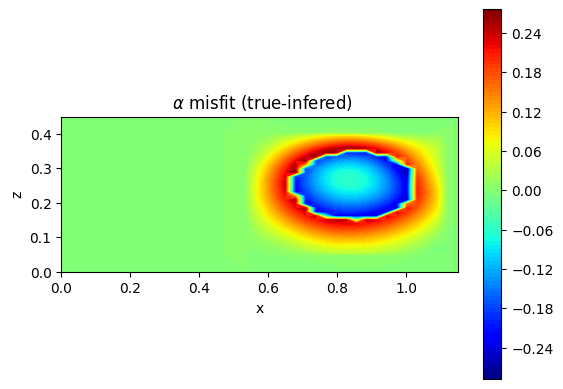

In [ ]:
#Here we define the true ground velocity
def g(x,z,a,b,c,d):
  return ((x-c)**2/a**2+(z-d)**2/b**2)

alpha_true=3-0.25*(1+tf.tanh(100*(1-g(x*Lx,z*Lz,0.18,0.1,1.0-n_absx*dx,0.3-n_absz*dz))))

with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      alpha_true0=sess.run([alpha_true], feed_dict =feed_dict01 )#note alpha takes two variables but feed_dict01 has three input. but it's ok and won't cause any issues
      alpha0=sess.run([alpha], feed_dict =feed_dict01 )

alpha_true0 = alpha_true0[0].reshape((xx.shape))

fig = plt.figure()
plt.contourf(xx*Lx, zz*Lx, alpha_true0-(alpha0[0].reshape(xx.shape)),100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title(r' $\alpha$ misfit (true-infered)')
plt.colorbar()
plt.axis('scaled')
plt.savefig('sample_data/PINN/infered_alpha_misfit.png',dpi=400)
plt.show()
plt.close(fig)

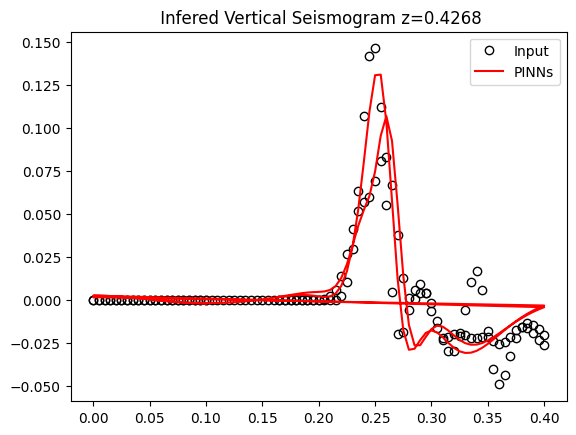

In [ ]:
import os
sms = sorted(os.listdir('drive/Shareddrives/Workshop/event1/seismograms/.'))
smsz = [f for f in sms if f[-6]=='Z']#Z cmp seismos
seismo_listz = [np.loadtxt('drive/Shareddrives/Workshop/event1/seismograms/'+f) for f in smsz]#Z cmp seismos

t_spec=-seismo_listz[0][0,0]+seismo_listz[0][:,0]#specfem's time doesn't start from zero for the seismos, so we shift it forward to zero
cut_u=t_spec>t_s#here we include only part of the seismograms from specfem that are within PINNs' training time domain which is [t_st t_m]
cut_l=t_spec<t_st#Cutting the seismograms to only after the time the first snapshot from specfem is used for PINNs
l_su=len(cut_u)-sum(cut_u)#this is the index of the time axis in specfem after which t>t_m
l_sl=sum(cut_l)

l_f=100#subsampling seismograms from specfem
index = np.arange(l_sl,l_su,l_f) #subsampling every l_s time steps from specfem in the training interval
l_sub=len(index)
t_spec_sub=t_spec[index].reshape((-1,1))#subsampled time axis of specfem for the seismograms
t_spec_sub=t_spec_sub-t_spec_sub[0]#shifting the time axis back to zero. length of t_spec_sub must be equal to t_m-t_st

for ii in range(len(seismo_listz)):
    seismo_listz[ii]=seismo_listz[ii][index]

Sz=seismo_listz[0][:,1].reshape(-1,1)
for ii in range(len(seismo_listz)-1):
    Sz=np.concatenate((Sz,seismo_listz[ii+1][:,1].reshape(-1,1)),axis=0)


n_event=1# number of seismic events
#################################################################
#######input seismograms for the rest of the events added to the first event
for ii in range(n_event-1):
    sms = sorted(os.listdir('event'+str(ii+2)+'/seismograms/.'))
    smsz = [f for f in sms if f[-6]=='Z']#Z cmp seismos
    seismo_listz = [np.loadtxt('event'+str(ii+2)+'/seismograms/'+f) for f in smsz]

    for jj in range(len(seismo_listz)):
        seismo_listz[jj]=seismo_listz[jj][index]


    Sze=seismo_listz[0][:,1].reshape(-1,1)
    for jj in range(len(seismo_listz)-1):
       Sze=np.concatenate((Sze,seismo_listz[jj+1][:,1].reshape(-1,1)),axis=0)

    Sz +=Sze
###########################################################
u_scl=1/3640 #scaling the output data to cover [-1 1] interval
Sz=Sz/u_scl #scaling the sum of all seismogram inputs

#X_S is the training collection of input coordinates in space-time for all seismograms
X_S=np.empty([int(np.size(Sz)), 3])
zl_s=0.06-n_absz*dz# z location of the last seismometer at depth. this doesn't have
z0_s=az# z location of the first seismometer from SPECFEM in PINN's refrence frame.Here it must
n_seis=20#number of input seismometers from SPECFEM; if events have different
d_s=np.abs((zl_s-z0_s))/(n_seis-1)#the distance between seismometers

for i in range(len(seismo_listz)):
  X_S[i*l_sub:(i+1)*l_sub,]=np.concatenate((ax/Lx*np.ones((l_sub,1),dtype=np.float64), \
                               (z0_s-i*d_s)/Lz*np.ones((l_sub,1),dtype=np.float64),t_spec_sub),axis=1)


feed_dict_seism={ x: X_S[:,0:1], z: X_S[:,1:2], t: X_S[:,2:3]}

with tf.Session() as sess:
    uz_seism_pred=sess.run([uz], feed_dict =feed_dict_seism )
    ux_seism_pred=sess.run([ux], feed_dict =feed_dict_seism )

fig = plt.figure()
plt.plot(X_S[600:750,2],Sz[600:750],'ok',mfc='none',label='Input')
plt.plot(X_S[600:750,2],uz_seism_pred[0][600:750],'r',label='PINNs')
plt.legend()
plt.title(r' Infered Vertical Seismogram z='+str(round(az-d_s, 4)))
plt.savefig('sample_data/PINN/Infered_ZSeismograms_compare_z='+str(round(az-d_s, 4))+'.png',dpi=400)
plt.show()
plt.close(fig)

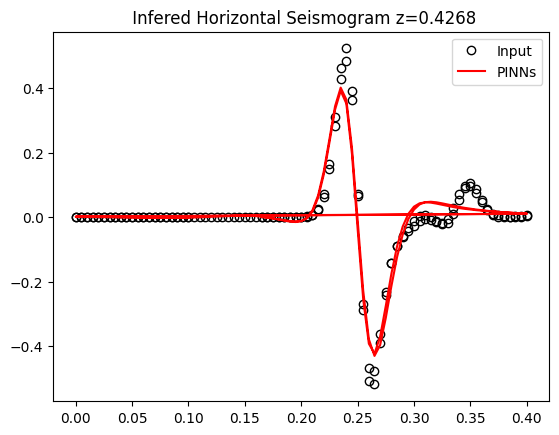

In [ ]:
import os
sms = sorted(os.listdir('drive/Shareddrives/Workshop/event1/seismograms/.'))
smsx = [f for f in sms if f[-6]=='X']#X cmp seismos
seismo_listx = [np.loadtxt('drive/Shareddrives/Workshop/event1/seismograms/'+f) for f in smsx]#X cmp seismos

for ii in range(len(seismo_listx)):
    seismo_listx[ii]=seismo_listx[ii][index]

Sx=seismo_listx[0][:,1].reshape(-1,1)
for ii in range(len(seismo_listx)-1):
    Sx=np.concatenate((Sx,seismo_listx[ii+1][:,1].reshape(-1,1)),axis=0)
#################################################################
#######input seismograms for the rest of the events added to the first event
for ii in range(n_event-1):
    sms = sorted(os.listdir('event'+str(ii+2)+'/seismograms/.'))
    smsx = [f for f in sms if f[-6]=='X']#X cmp seismos
    seismo_listx = [np.loadtxt('event'+str(ii+2)+'/seismograms/'+f) for f in smsx]

    for jj in range(len(seismo_listx)):
        seismo_listx[jj]=seismo_listx[jj][index]

    Sxe=seismo_listx[0][:,1].reshape(-1,1)
    for jj in range(len(seismo_listx)-1):
       Sxe=np.concatenate((Sxe,seismo_listx[jj+1][:,1].reshape(-1,1)),axis=0)

    Sx +=Sxe
###########################################################
Sx=Sx/u_scl #scaling the sum of all seismogram inputs

fig = plt.figure()
plt.plot(X_S[600:750,2],Sx[600:750],'ok',mfc='none',label='Input')
plt.plot(X_S[600:750,2],ux_seism_pred[0][600:750],'r',label='PINNs')
plt.legend()
plt.title(r' Infered Horizontal Seismogram z='+str(round(az-d_s, 4)))
plt.savefig('sample_data/PINN/Infered XSeismograms_compare_z='+str(round(az-d_s, 4))+'.png',dpi=400)
plt.show()
plt.close(fig)